In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer,Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout ,LSTM, Input
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow.keras.backend as K
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error ,r2_score
import matplotlib.pyplot as plt
import time
import keras_tuner as kt
import seaborn as sns

In [2]:
#a
# uploading data
cols = ['unit_number', 'time_in_cycles'] + \
       [f'op_setting_{i}' for i in range(1, 4)] + \
       [f'sensor_measurement_{i}' for i in range(1, 22)]
#train
train_FD1 = r'6. Turbofan Engine Degradation Simulation Data Set\train_FD001.txt'
train_df = pd.read_csv(train_FD1, sep=' ', header=None)
train_df.dropna(axis=1, inplace=True)
train_df.columns = cols
train_df.info()
#test
test_FD1 = r'6. Turbofan Engine Degradation Simulation Data Set\test_FD001.txt'
test_df = pd.read_csv(test_FD1, sep=' ', header=None)
test_df.dropna(axis=1, inplace=True)
test_df.columns = cols
#real_RUL
real_RUL = r'6. Turbofan Engine Degradation Simulation Data Set\RUL_FD001.txt'
rul_t = pd.read_csv(real_RUL, sep=' ', header=None)
rul_t = rul_t.dropna(axis=1)
rul_t.columns = ['RUL']
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unit_number            20631 non-null  int64  
 1   time_in_cycles         20631 non-null  int64  
 2   op_setting_1           20631 non-null  float64
 3   op_setting_2           20631 non-null  float64
 4   op_setting_3           20631 non-null  float64
 5   sensor_measurement_1   20631 non-null  float64
 6   sensor_measurement_2   20631 non-null  float64
 7   sensor_measurement_3   20631 non-null  float64
 8   sensor_measurement_4   20631 non-null  float64
 9   sensor_measurement_5   20631 non-null  float64
 10  sensor_measurement_6   20631 non-null  float64
 11  sensor_measurement_7   20631 non-null  float64
 12  sensor_measurement_8   20631 non-null  float64
 13  sensor_measurement_9   20631 non-null  float64
 14  sensor_measurement_10  20631 non-null  float64
 15  se

In [3]:
train_df.describe() 

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [4]:
train_df.head()

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
# calculate RUL
rul_df = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul_df.columns = ['unit_number', 'max_cycle']
train_df = train_df.merge(rul_df, on='unit_number')
train_df['RUL'] = train_df['max_cycle'] - train_df['time_in_cycles']
train_df.head()


max_cycles = test_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycle']
max_cycles['true_RUL'] = rul_t['RUL']
max_cycles['total_life'] = max_cycles['max_cycle'] + max_cycles['true_RUL']
test_df = test_df.merge(max_cycles[['unit_number', 'total_life']], on='unit_number')
test_df['RUL'] = test_df['total_life'] - test_df['time_in_cycles']

In [6]:
sensor_cols = [col for col in train_df.columns if "sensor" in col]
selector = VarianceThreshold(threshold=0.005)
selector.fit(train_df[sensor_cols])
useful_sensor_cols = list(selector.get_feature_names_out(sensor_cols))

In [7]:
corr_matrix = train_df[useful_sensor_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.99)]
filtered_cols = [col for col in useful_sensor_cols if col not in to_drop]

In [8]:
cor_with_target = train_df[filtered_cols + ['RUL']].corr()['RUL'].abs().drop('RUL')
low_corr_features = cor_with_target[cor_with_target < 0.03].index.tolist()  
final_sensor_cols = [col for col in filtered_cols if col not in low_corr_features]

In [9]:
X_rf = train_df[final_sensor_cols]
y_rf = train_df['RUL']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_rf, y_rf)
importances = pd.Series(rf.feature_importances_, index=final_sensor_cols)
low_importance_features = importances[importances < 0.005].index.tolist()

selected_features = [col for col in final_sensor_cols if col not in low_importance_features]

In [10]:
train_df = train_df[selected_features + ['RUL', 'unit_number', 'time_in_cycles']]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sensor_measurement_2   20631 non-null  float64
 1   sensor_measurement_3   20631 non-null  float64
 2   sensor_measurement_4   20631 non-null  float64
 3   sensor_measurement_7   20631 non-null  float64
 4   sensor_measurement_8   20631 non-null  float64
 5   sensor_measurement_9   20631 non-null  float64
 6   sensor_measurement_11  20631 non-null  float64
 7   sensor_measurement_12  20631 non-null  float64
 8   sensor_measurement_13  20631 non-null  float64
 9   sensor_measurement_14  20631 non-null  float64
 10  sensor_measurement_17  20631 non-null  int64  
 11  sensor_measurement_20  20631 non-null  float64
 12  sensor_measurement_21  20631 non-null  float64
 13  RUL                    20631 non-null  int64  
 14  unit_number            20631 non-null  int64  
 15  ti

In [11]:
scaler = MinMaxScaler()
train_df_scaled = train_df.copy()
train_df_scaled[selected_features] = scaler.fit_transform(train_df[selected_features])

test_df_scaled = test_df.copy()
test_df_scaled[selected_features] = scaler.transform(test_df[selected_features])

In [12]:
print(type(train_df))

<class 'pandas.core.frame.DataFrame'>


In [13]:
unique_units = train_df_scaled['unit_number'].unique()
train_units = unique_units[:int(0.7 * len(unique_units))]
val_units = unique_units[int(0.7 * len(unique_units)):]

def prepare_windows(data, window_size=30):
    X, y = [], []
    for unit in data['unit_number'].unique():
        unit_data = data[data['unit_number'] == unit].sort_values('time_in_cycles')
        features = unit_data[selected_features].values
        rul = unit_data['RUL'].values
        for i in range(len(unit_data) - window_size + 1):
            X.append(features[i:i + window_size])
            y.append(rul[i + window_size - 1])
    return np.array(X), np.array(y)

X, y = prepare_windows(train_df_scaled, window_size=30)
X_test, y_test = prepare_windows(test_df_scaled)
print(X.shape)
print(X_test.shape)

(17731, 30, 13)
(10196, 30, 13)


In [14]:
X_train, y_train = prepare_windows(train_df_scaled[train_df_scaled['unit_number'].isin(train_units)])
X_val, y_val = prepare_windows(train_df_scaled[train_df_scaled['unit_number'].isin(val_units)])

In [15]:
max_rul = 130
train_df['RUL'] = train_df['RUL'].clip(upper=max_rul)
test_df['RUL'] = test_df['RUL'].clip(upper=max_rul)

# a-2


In [16]:
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(X.shape[1], X.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  
])

model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [17]:
early_stop_cnn = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

start_time_cnn = time.time()
history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_cnn],
    verbose=1
)
train_time_cnn = time.time() - start_time_cnn

Epoch 1/100


190/190 [==============================] - 2s 4ms/step - loss: 4014.6614 - mae: 48.1761 - val_loss: 2156.5476 - val_mae: 34.3485
Epoch 2/100
190/190 [==============================] - 1s 3ms/step - loss: 1695.8582 - mae: 30.1769 - val_loss: 1959.4285 - val_mae: 33.9911
Epoch 3/100
190/190 [==============================] - 1s 3ms/step - loss: 1616.9448 - mae: 29.2487 - val_loss: 1977.8970 - val_mae: 32.5170
Epoch 4/100
190/190 [==============================] - 1s 3ms/step - loss: 1567.3040 - mae: 28.7142 - val_loss: 1891.7435 - val_mae: 33.1627
Epoch 5/100
190/190 [==============================] - 1s 3ms/step - loss: 1559.8706 - mae: 28.6399 - val_loss: 1820.0823 - val_mae: 31.9960
Epoch 6/100
190/190 [==============================] - 1s 3ms/step - loss: 1559.7083 - mae: 28.5606 - val_loss: 1843.8516 - val_mae: 31.5756
Epoch 7/100
190/190 [==============================] - 1s 3ms/step - loss: 1544.1691 - mae: 28.2883 - val_loss: 1858.6031 - val_mae: 31.1030
Epoch 8/100

190/190 [==============================] - 1s 3ms/step - loss: 940.2574 - mae: 20.7885 - val_loss: 1333.6075 - val_mae: 24.9745
Epoch 56/100
190/190 [==============================] - 1s 3ms/step - loss: 926.1066 - mae: 20.7099 - val_loss: 1504.1414 - val_mae: 25.7326
Epoch 57/100
190/190 [==============================] - 1s 3ms/step - loss: 935.3025 - mae: 20.7086 - val_loss: 1469.0569 - val_mae: 25.5345
Epoch 58/100
190/190 [==============================] - 1s 3ms/step - loss: 916.4832 - mae: 20.6255 - val_loss: 1367.3344 - val_mae: 25.4707
Epoch 59/100
190/190 [==============================] - 1s 3ms/step - loss: 925.0709 - mae: 20.5836 - val_loss: 1557.4369 - val_mae: 25.9151
Epoch 60/100
190/190 [==============================] - 1s 3ms/step - loss: 918.9038 - mae: 20.5796 - val_loss: 1533.5958 - val_mae: 25.3942
Epoch 61/100
190/190 [==============================] - 1s 3ms/step - loss: 906.2656 - mae: 20.3596 - val_loss: 1545.3904 - val_mae: 25.6551
Epoch 62/100
190/190 [====

In [18]:
y_pred_cnn = model_cnn.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred_cnn)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
log_rmse = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred_cnn)))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"log-RMSE: {log_rmse:.2f}")

319/319 [==============================] - 0s 1ms/step
MAE: 28.95
RMSE: 38.93
log-RMSE: 0.29


# a-3

In [19]:
model_lstm = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1) 
])

model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [20]:
early_stop_lstm = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start_time_lstm = time.time()
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_lstm],
    verbose=1
)
train_time_lstm = time.time() - start_time_lstm

Epoch 1/100
190/190 [==============================] - 7s 24ms/step - loss: 6623.5410 - mae: 63.6096 - val_loss: 4642.9092 - val_mae: 54.3745
Epoch 2/100
190/190 [==============================] - 4s 21ms/step - loss: 3645.9158 - mae: 49.1226 - val_loss: 4515.0962 - val_mae: 54.0339
Epoch 3/100
190/190 [==============================] - 4s 21ms/step - loss: 3649.2842 - mae: 49.1108 - val_loss: 4460.7397 - val_mae: 53.9375
Epoch 4/100
190/190 [==============================] - 4s 21ms/step - loss: 3653.6152 - mae: 49.2701 - val_loss: 4494.9634 - val_mae: 53.9930
Epoch 5/100
190/190 [==============================] - 4s 20ms/step - loss: 3645.7590 - mae: 49.2054 - val_loss: 4424.1221 - val_mae: 53.9129
Epoch 6/100
190/190 [==============================] - 4s 20ms/step - loss: 3645.5901 - mae: 49.1983 - val_loss: 4483.5088 - val_mae: 53.9694
Epoch 7/100
190/190 [==============================] - 4s 20ms/step - loss: 3252.1497 - mae: 45.3605 - val_loss: 2419.8218 - val_mae: 36.2957
Epoch 

In [21]:
y_pred_lstm = model_lstm.predict(X_test).flatten()

mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
log_rmse_lstm = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred_lstm)))

print(f"LSTM MAE: {mae_lstm:.2f}")
print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM log-RMSE: {log_rmse_lstm:.2f}")

319/319 [==============================] - 2s 5ms/step
LSTM MAE: 27.31
LSTM RMSE: 36.81
LSTM log-RMSE: 0.27


# a-4

In [22]:
def build_cnn_model(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Int('filters1', 32, 128, step=32),
        kernel_size=hp.Choice('kernel_size', [2, 3, 5]),
        activation='relu',
        padding='same',
        input_shape=(X.shape[1], X.shape[2])
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(
        filters=hp.Int('filters2', 32, 128, step=32),
        kernel_size=3,
        activation='relu',
        padding='same'
    ))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    
    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=lr) if optimizer_name == 'adam' else RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('lstm_units1', 50, 200, step=50),
        return_sequences=True,
        input_shape=(X.shape[1], X.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))
    model.add(LSTM(
        units=hp.Int('lstm_units2', 50, 150, step=50),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    
    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=lr) if optimizer_name == 'adam' else RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


tuner_cnn = kt.RandomSearch(
    build_cnn_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='cnn_tuning',
    project_name='cnn_rul',
    overwrite=True,
    seed=42
)

tuner_cnn.search(X_train, y_train,
                 epochs=50,
                 validation_data=(X_val, y_val),
                 batch_size=64,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                 verbose=1)

tuner_lstm = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='lstm_rul',
    overwrite=True,
    seed=42
)

tuner_lstm.search(X_train, y_train,
                  epochs=50,
                  validation_data=(X_val, y_val),
                  batch_size=64,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                  verbose=1)

best_cnn_model = tuner_cnn.get_best_models(1)[0]
cnn_test_loss, cnn_test_mae = best_cnn_model.evaluate(X_test, y_test)
best_cnn_hps = tuner_cnn.get_best_hyperparameters(1)[0]


print("🔷 Best CNN Hyperparameters:")
print("filters1:", best_cnn_hps.get('filters1'))
print("filters2:", best_cnn_hps.get('filters2'))
print("kernel_size:", best_cnn_hps.get('kernel_size'))
print("dropout_rate:", best_cnn_hps.get('dropout_rate'))
print("optimizer:", best_cnn_hps.get('optimizer'))
print("learning_rate:", best_cnn_hps.get('learning_rate'))
print(f"CNN Test MAE: {cnn_test_mae:.4f}\n")

best_lstm_model = tuner_lstm.get_best_models(1)[0]
lstm_test_loss, lstm_test_mae = best_lstm_model.evaluate(X_test, y_test)
best_lstm_hps = tuner_lstm.get_best_hyperparameters(1)[0]

print("🔶 Best LSTM Hyperparameters:")
print("lstm_units1:", best_lstm_hps.get('lstm_units1'))
print("lstm_units2:", best_lstm_hps.get('lstm_units2'))
print("dropout1:", best_lstm_hps.get('dropout1'))
print("dropout2:", best_lstm_hps.get('dropout2'))
print("optimizer:", best_lstm_hps.get('optimizer'))
print("learning_rate:", best_lstm_hps.get('learning_rate'))
print(f"LSTM Test MAE: {lstm_test_mae:.4f}")

Trial 10 Complete [00h 01m 42s]
val_loss: 1222.921142578125

Best val_loss So Far: 1116.1243896484375
Total elapsed time: 00h 17m 20s

319/319 [==============================] - 1s 1ms/step - loss: 1695.4205 - mae: 30.5204
🔷 Best CNN Hyperparameters:
filters1: 96
filters2: 128
kernel_size: 2
dropout_rate: 0.1
optimizer: adam
learning_rate: 0.01
CNN Test MAE: 30.5204

319/319 [==============================] - 3s 6ms/step - loss: 1377.5986 - mae: 27.1569
🔶 Best LSTM Hyperparameters:
lstm_units1: 100
lstm_units2: 100
dropout1: 0.1
dropout2: 0.30000000000000004
optimizer: adam
learning_rate: 0.001
LSTM Test MAE: 27.1569


🔷 CNN Trials Results Table:
   filters1  kernel_size  filters2  dropout_rate optimizer  learning_rate  \
6        96            2       128           0.1      adam         0.0100   
1       128            2       128           0.1   rmsprop         0.0100   
8        64            2        64           0.3      adam         0.0010   
3        32            2        96           0.4   rmsprop         0.0100   
5       128            2        64           0.3      adam         0.0010   
2        64            3       128           0.3      adam         0.0010   
0        96            2        64           0.2   rmsprop         0.0010   
9        32            5       128           0.5   rmsprop         0.0100   
4        32            2       128           0.3      adam         0.0001   
7        32            2        64           0.5   rmsprop         0.0001   

      val_loss        mae  
6  1359.018799  20.181114  
1  1500.030762  24.325405  
8  1504.778931  24.027250  
3  1508.3775

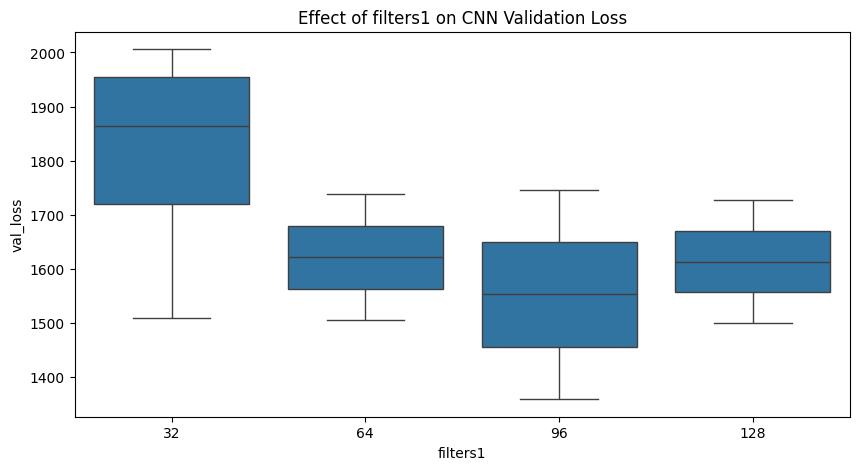

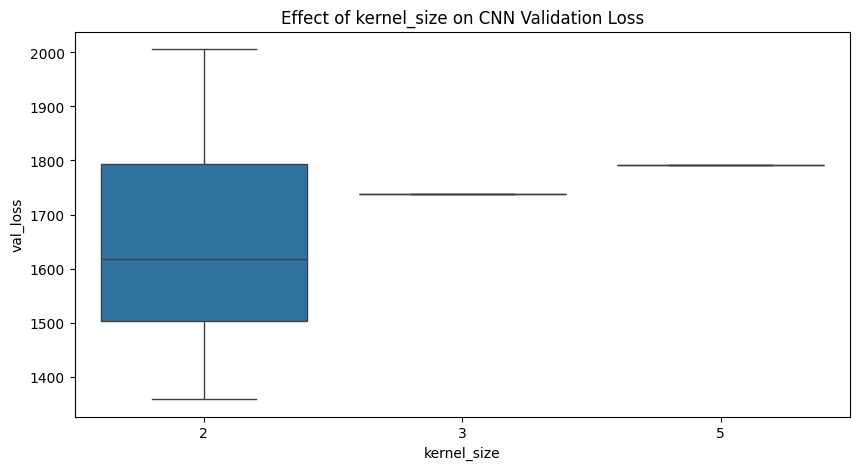

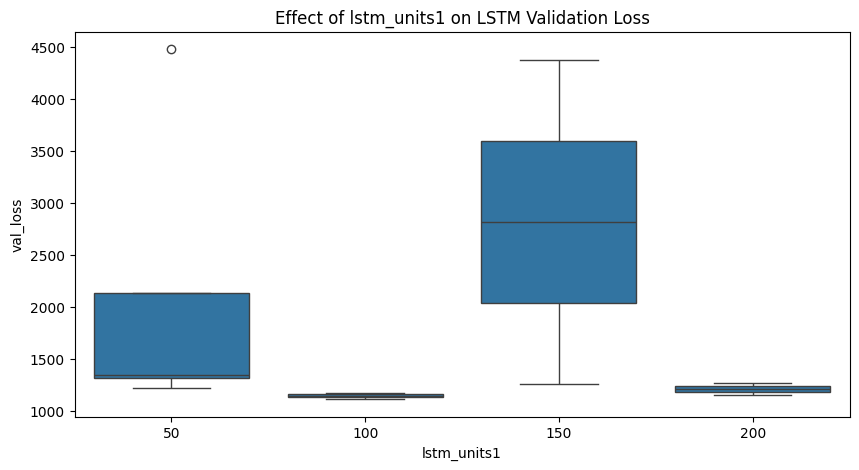

In [23]:
# -------- Extract CNN Trials Data --------
cnn_trials = tuner_cnn.oracle.trials.values()
cnn_results = []

for trial in cnn_trials:
    hp = trial.hyperparameters.values
    hp['val_loss'] = trial.metrics.get_last_value('val_loss')
    hp['mae'] = trial.metrics.get_last_value('mae')
    cnn_results.append(hp)

df_cnn = pd.DataFrame(cnn_results)
print("🔷 CNN Trials Results Table:")
print(df_cnn.sort_values('val_loss'))  

# -------- Extract LSTM Trials Data --------
lstm_trials = tuner_lstm.oracle.trials.values()
lstm_results = []

for trial in lstm_trials:
    hp = trial.hyperparameters.values
    hp['val_loss'] = trial.metrics.get_last_value('val_loss')
    hp['mae'] = trial.metrics.get_last_value('mae')
    lstm_results.append(hp)

df_lstm = pd.DataFrame(lstm_results)
print("🔶 LSTM Trials Results Table:")
print(df_lstm.sort_values('val_loss'))

# -------- Visual Analysis: Effect of Hyperparameters --------
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_cnn, x='filters1', y='val_loss')
plt.title('Effect of filters1 on CNN Validation Loss')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_cnn, x='kernel_size', y='val_loss')
plt.title('Effect of kernel_size on CNN Validation Loss')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_lstm, x='lstm_units1', y='val_loss')
plt.title('Effect of lstm_units1 on LSTM Validation Loss')
plt.show()

# a-5

In [24]:
model_cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(X.shape[1], X.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)  
])
model_cnn_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [25]:
early_stop_cnn_lstm = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start_time_cnn_lstm = time.time()
history_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_cnn_lstm],
    verbose=1
)
train_time_cnn_lstm = time.time() - start_time_cnn_lstm

Epoch 1/100
190/190 [==============================] - 3s 10ms/step - loss: 5315.4868 - mae: 57.4075 - val_loss: 4499.6108 - val_mae: 53.9879
Epoch 2/100
190/190 [==============================] - 2s 9ms/step - loss: 2314.4036 - mae: 35.7852 - val_loss: 1871.5839 - val_mae: 30.4531
Epoch 3/100
190/190 [==============================] - 2s 8ms/step - loss: 1323.1266 - mae: 25.6591 - val_loss: 1675.8311 - val_mae: 28.6268
Epoch 4/100
190/190 [==============================] - 2s 8ms/step - loss: 1161.3253 - mae: 23.7003 - val_loss: 1605.8876 - val_mae: 26.1174
Epoch 5/100
190/190 [==============================] - 2s 9ms/step - loss: 1034.8104 - mae: 21.9972 - val_loss: 1304.2902 - val_mae: 23.7610
Epoch 6/100
190/190 [==============================] - 2s 9ms/step - loss: 993.6888 - mae: 21.5407 - val_loss: 1501.0238 - val_mae: 25.2698
Epoch 7/100
190/190 [==============================] - 2s 9ms/step - loss: 933.0530 - mae: 20.7176 - val_loss: 1253.8254 - val_mae: 23.5034
Epoch 8/100
19

In [26]:
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test).flatten()

mae_cnn_lstm = mean_absolute_error(y_test, y_pred_cnn_lstm)
rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test, y_pred_cnn_lstm))
log_rmse_cnn_lstm = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred_cnn_lstm)))

print(f"CNN-LSTM MAE: {mae_cnn_lstm:.2f}")
print(f"CNN-LSTM RMSE: {rmse_cnn_lstm:.2f}")
print(f"CNN-LSTM log-RMSE: {log_rmse_cnn_lstm:.2f}")

319/319 [==============================] - 1s 2ms/step
CNN-LSTM MAE: 27.52
CNN-LSTM RMSE: 37.50
CNN-LSTM log-RMSE: 0.27


In [27]:
model_lstm_cnn = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])
model_lstm_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [28]:
start_time_lstm_cnn = time.time()
history_lstm_cnn = model_lstm_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_cnn_lstm],
    verbose=1
)
train_time_lstm_cnn = time.time() - start_time_lstm_cnn

Epoch 1/100
190/190 [==============================] - 4s 16ms/step - loss: 4855.7134 - mae: 55.1849 - val_loss: 3580.6355 - val_mae: 46.5081
Epoch 2/100
190/190 [==============================] - 3s 14ms/step - loss: 2592.7791 - mae: 40.0775 - val_loss: 2766.4062 - val_mae: 40.8901
Epoch 3/100
190/190 [==============================] - 3s 14ms/step - loss: 2079.6660 - mae: 34.8960 - val_loss: 2280.9851 - val_mae: 35.7649
Epoch 4/100
190/190 [==============================] - 3s 14ms/step - loss: 1883.6162 - mae: 32.5024 - val_loss: 2176.2056 - val_mae: 33.9046
Epoch 5/100
190/190 [==============================] - 3s 14ms/step - loss: 1746.7871 - mae: 30.8499 - val_loss: 1889.8041 - val_mae: 32.7732
Epoch 6/100
190/190 [==============================] - 3s 14ms/step - loss: 1625.7959 - mae: 29.2941 - val_loss: 1968.6576 - val_mae: 34.4189
Epoch 7/100
190/190 [==============================] - 3s 14ms/step - loss: 1539.1387 - mae: 28.3245 - val_loss: 2040.8956 - val_mae: 31.8616
Epoch 

In [29]:
y_pred_lstm_cnn = model_lstm_cnn.predict(X_test).flatten()

mae_lstm_cnn = mean_absolute_error(y_test, y_pred_lstm_cnn)
rmse_lstm_cnn = np.sqrt(mean_squared_error(y_test, y_pred_lstm_cnn))
log_rmse_lstm_cnn = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred_lstm_cnn)))
r2_lstm_cnn = r2_score(y_test, y_pred_lstm_cnn)


print(f"LSTM-CNN MAE: {mae_lstm_cnn:.2f}")
print(f"LSTM-CNN RMSE: {rmse_lstm_cnn:.2f}")
print(f"LSTM-CNN log-RMSE: {log_rmse_lstm_cnn:.2f}")

319/319 [==============================] - 2s 4ms/step
LSTM-CNN MAE: 29.47
LSTM-CNN RMSE: 38.38
LSTM-CNN log-RMSE: 0.29


# a-6

In [30]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

input_layer = Input(shape=(X.shape[1], X.shape[2]))
lstm_out = LSTM(100, return_sequences=True)(input_layer)
dropout = Dropout(0.3)(lstm_out)
attention_out = AttentionLayer()(dropout)
dense1 = Dense(64, activation='relu')(attention_out)
dropout2 = Dropout(0.3)(dense1)
output = Dense(1)(dropout2)

model_lstm_att = Model(inputs=input_layer, outputs=output)

model_lstm_att.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001),
    metrics=['mae']
)

In [31]:
start_time_lstm_att = time.time()
history_lstm_att = model_lstm_att.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)
train_time_lstm_att = time.time() - start_time_lstm_att

Epoch 1/100
190/190 [==============================] - 4s 16ms/step - loss: 5342.9951 - mae: 57.4578 - val_loss: 4473.4771 - val_mae: 53.9369
Epoch 2/100
190/190 [==============================] - 3s 16ms/step - loss: 3245.4031 - mae: 45.2077 - val_loss: 2862.4714 - val_mae: 39.6680
Epoch 3/100
190/190 [==============================] - 3s 16ms/step - loss: 1998.0671 - mae: 33.1822 - val_loss: 2108.2834 - val_mae: 33.4041
Epoch 4/100
190/190 [==============================] - 3s 14ms/step - loss: 1695.7344 - mae: 29.6707 - val_loss: 1893.4191 - val_mae: 32.1178
Epoch 5/100
190/190 [==============================] - 3s 15ms/step - loss: 1574.3063 - mae: 28.1540 - val_loss: 1772.3699 - val_mae: 29.6110
Epoch 6/100
190/190 [==============================] - 3s 16ms/step - loss: 1412.6119 - mae: 26.2855 - val_loss: 1571.1471 - val_mae: 28.5001
Epoch 7/100
190/190 [==============================] - 3s 15ms/step - loss: 1302.2046 - mae: 25.1162 - val_loss: 2522.7273 - val_mae: 33.3064
Epoch 

In [32]:
y_pred_att = model_lstm_att.predict(X_test).flatten()
mae_att = mean_absolute_error(y_test, y_pred_att)
rmse_att = np.sqrt(mean_squared_error(y_test, y_pred_att))
log_rmse_att = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred_att)))

print(f"LSTM + Attention MAE: {mae_att:.2f}")
print(f"LSTM + Attention RMSE: {rmse_att:.2f}")
print(f"LSTM + Attention log-RMSE: {log_rmse_att:.2f}")

319/319 [==============================] - 1s 4ms/step
LSTM + Attention MAE: 28.92
LSTM + Attention RMSE: 38.58
LSTM + Attention log-RMSE: 0.28


# B

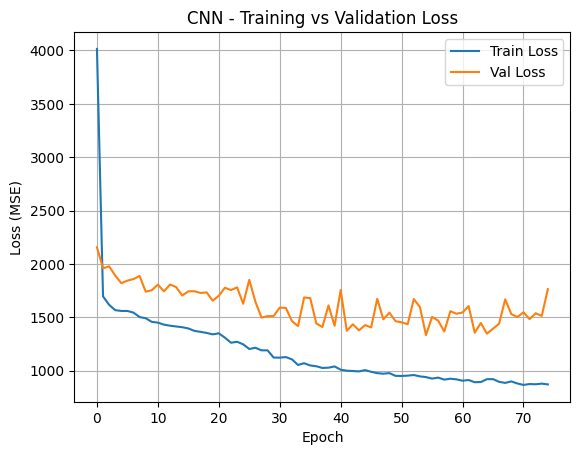

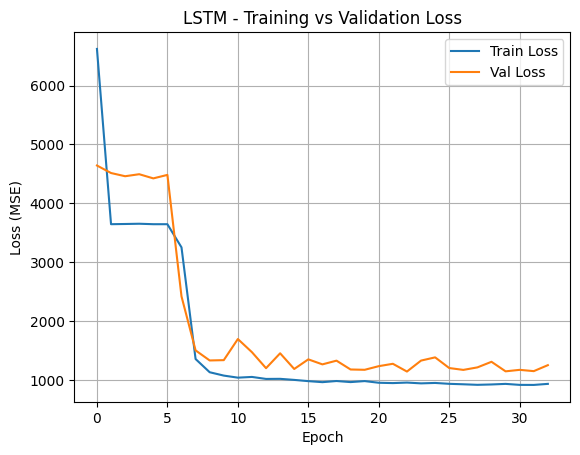

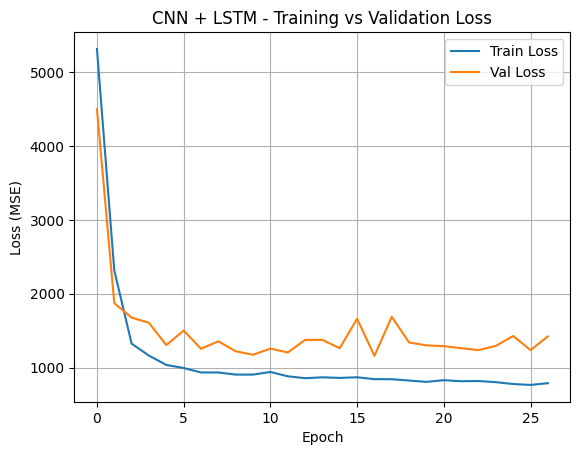

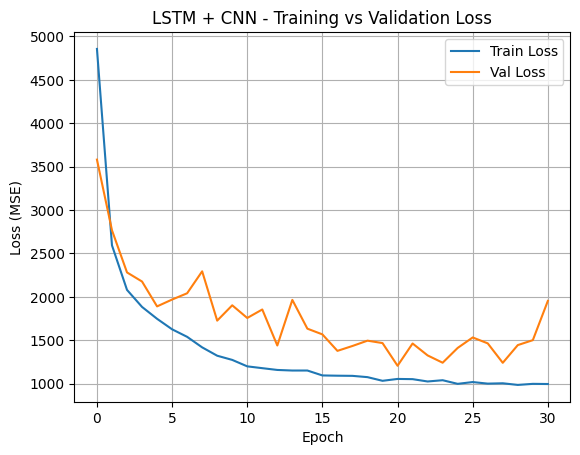

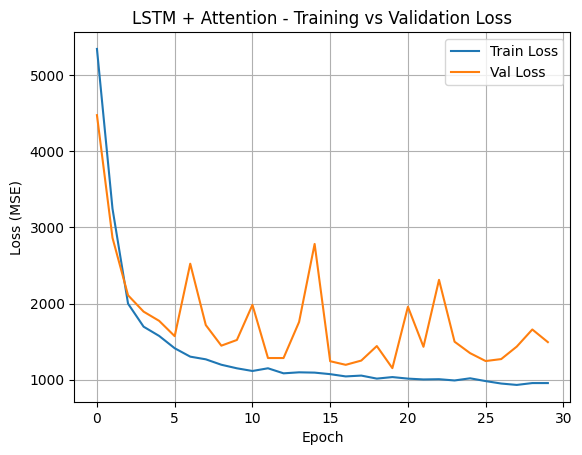

In [33]:
def plot_loss(history, model_name):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss(history_cnn, "CNN")
plot_loss(history_lstm, "LSTM")
plot_loss(history_cnn_lstm, "CNN + LSTM")
plot_loss(history_lstm_cnn, "LSTM + CNN")
plot_loss(history_lstm_att, "LSTM + Attention")

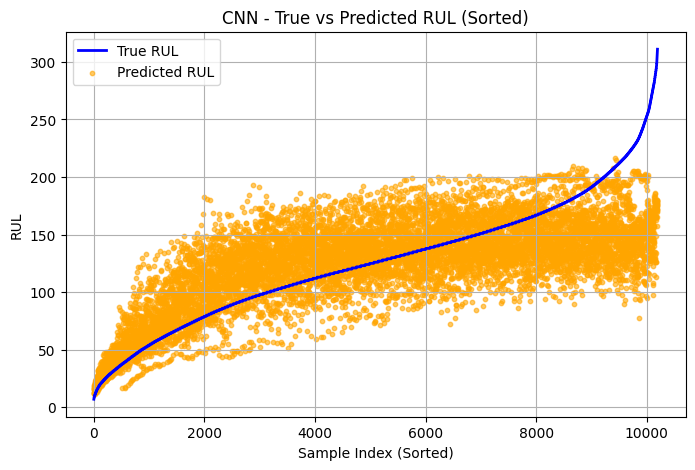

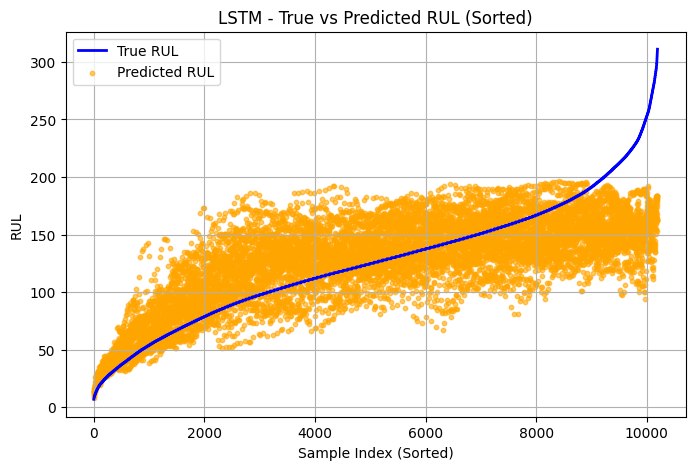

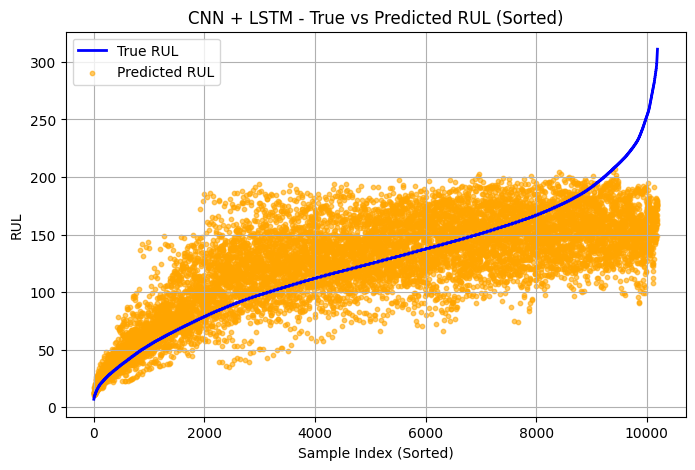

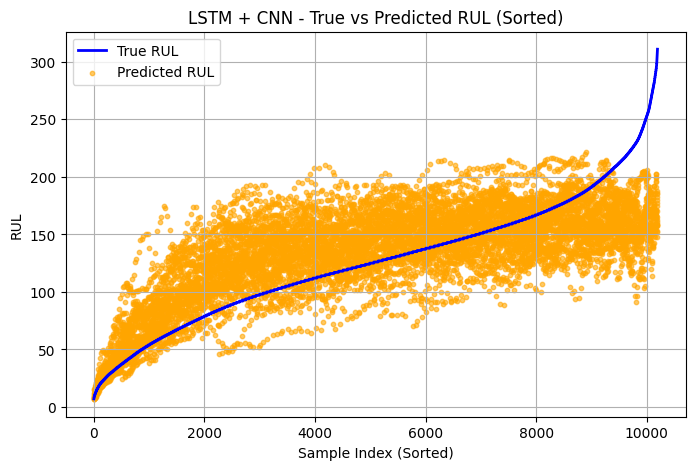

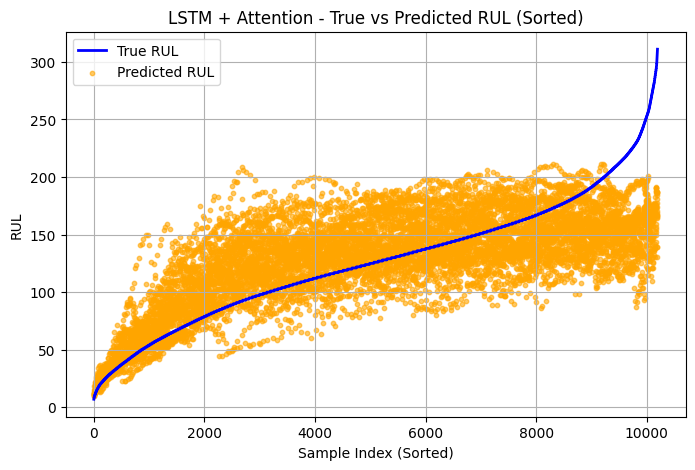

In [34]:
def plot_pred_vs_true(y_true, y_pred, model_name):
    sorted_indices = np.argsort(y_true)
    y_true_sorted = np.array(y_true)[sorted_indices]
    y_pred_sorted = np.array(y_pred)[sorted_indices]

    plt.figure(figsize=(8,5))
    plt.plot(y_true_sorted, label='True RUL', color='blue', linewidth=2)
    plt.scatter(range(len(y_pred_sorted)), y_pred_sorted, label='Predicted RUL', color='orange', alpha=0.6, s=10)
    plt.title(f'{model_name} - True vs Predicted RUL (Sorted)')
    plt.xlabel('Sample Index (Sorted)')
    plt.ylabel('RUL')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pred_vs_true(y_test, y_pred_cnn, "CNN")
plot_pred_vs_true(y_test, y_pred_lstm, "LSTM")
plot_pred_vs_true(y_test, y_pred_cnn_lstm, "CNN + LSTM")
plot_pred_vs_true(y_test, y_pred_lstm_cnn, "LSTM + CNN")
plot_pred_vs_true(y_test, y_pred_att, "LSTM + Attention")

In [35]:
def evaluate_model(y_true, y_pred, training_time):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    log_rmse = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))  # log1p = log(1 + x) for stability

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Training Time (s)': training_time,
        'MAPE (%)': mape,
        'log-RMSE': log_rmse
    }

In [36]:
results = []

results.append({'Model': 'CNN', **evaluate_model(y_test, y_pred_cnn, train_time_cnn)})
results.append({'Model': 'LSTM', **evaluate_model(y_test, y_pred_lstm, train_time_lstm)})
results.append({'Model': 'CNN + LSTM', **evaluate_model(y_test, y_pred_cnn_lstm, train_time_cnn_lstm)})
results.append({'Model': 'LSTM + CNN', **evaluate_model(y_test, y_pred_lstm_cnn, train_time_lstm_cnn)})  
results.append({'Model': 'LSTM + Attention', **evaluate_model(y_test, y_pred_att, train_time_lstm_att)})

results_df = pd.DataFrame(results)
results_df

,Model,RMSE,MAE,R²,Training Time (s),MAPE (%),log-RMSE
0,CNN,38.931452,28.949978,0.491303,48.670199,24.153523,0.287792
1,LSTM,36.808776,27.306557,0.545262,132.166664,23.017971,0.270853
2,CNN + LSTM,37.499010,27.524084,0.528048,45.300407,22.506778,0.271823
3,LSTM + CNN,38.379490,29.469776,0.505625,87.411211,26.041388,0.291155
4,LSTM + Attention,38.577016,28.918768,0.500523,85.424902,24.002287,0.280161


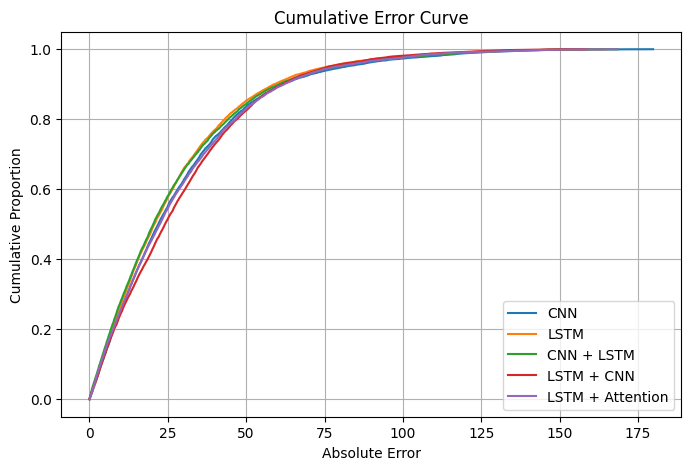

In [37]:
def plot_cumulative_error(y_true, y_pred, model_name):
    errors = np.abs(y_true - y_pred)
    sorted_errors = np.sort(errors)
    cumulative = np.arange(1, len(errors)+1) / len(errors)
    plt.plot(sorted_errors, cumulative, label=model_name)

plt.figure(figsize=(8,5))
plot_cumulative_error(y_test, y_pred_cnn, "CNN")
plot_cumulative_error(y_test, y_pred_lstm, "LSTM")
plot_cumulative_error(y_test, y_pred_cnn_lstm, "CNN + LSTM")
plot_cumulative_error(y_test, y_pred_lstm_cnn, "LSTM + CNN")  
plot_cumulative_error(y_test, y_pred_att, "LSTM + Attention")
plt.xlabel("Absolute Error")
plt.ylabel("Cumulative Proportion")
plt.title("Cumulative Error Curve")
plt.grid(True)
plt.legend()
plt.show()